# **Breaking SAT CAPTCHAs with Machine Learning**
_Alfredo Villasenor-Monsivais_<br>
_Alejandra G. Silva-Trujillo_<br>
_Juan C. Cuevas-Tello_

In [6]:
import time
import re
import base64
import os
import pyperclip
import numpy as np
import pandas as pd
from datetime import datetime
from io import BytesIO
from PIL import Image, ImageDraw
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from twocaptcha import TwoCaptcha
from IPython.display import display, clear_output

In [2]:
# Configurar opciones para ejecutar en segundo plano (headless)
firefox_options = Options()
firefox_options.add_argument("--headless")  # Modo sin interfaz gráfica

# Inicializar WebDriver con opciones
driver = webdriver.Firefox(options=firefox_options)

# Acceder a la página (sin abrir ventana)
driver.get("https://login.siat.sat.gob.mx/nidp/app/")
print("WebDriver inicializado.")

# Configurar 2Captcha
solver = TwoCaptcha('a04de98e78dd8976ba65b1a7300d461a')

# Obtener la fecha actual en formato DD-MM-YYYY
fecha_actual = datetime.now().strftime("%d-%m-%Y")

# Crear la carpeta si no existe
os.makedirs(fecha_actual, exist_ok=True)

# Definir la ruta del archivo temporal
temp_filename = os.path.join(fecha_actual, "temp_captcha.png")

for i in range(13):
    clear_output(wait=True)  # Limpiar la salida de la celda
    driver.refresh()  # Refrescar la página para obtener un nuevo CAPTCHA

    # Manejar posibles alertas
    try:
        alert = driver.switch_to.alert
        alert.accept()
    except Exception:
        pass

    time.sleep(4)  # Esperar a que se genere el CAPTCHA

    # Obtener el código fuente de la página
    page_source = driver.page_source
    
    # Buscar la imagen CAPTCHA en base64
    match = re.search(r'<img src="data:image/jpeg;base64,([^"]+)"', page_source)

    if match:
        base64_string = match.group(1)
        image_data = base64.b64decode(base64_string)
        image = Image.open(BytesIO(image_data))
        
        print(f"CAPTCHA #{i+1}:")
        display(image)

        # Guardar temporalmente la imagen en la carpeta
        image.save(temp_filename)

        # Esperar hasta recibir una respuesta válida de 2Captcha
        captcha_code = None
        print("Esperando respuesta de 2Captcha...")
        while not captcha_code:  # No se avanza hasta obtener una respuesta
            try:
                result = solver.normal(temp_filename, numeric=4, minLen=6, maxLen=6)  # Resolver el CAPTCHA
                captcha_id = result.get("captchaId")  # Obtener el id del captcha
                captcha_code = result.get("code", "").upper()  # Convertir a mayúsculas
            except Exception as e:
                print(f"Error capturado: {e}")
                time.sleep(3)  # Esperar 3 segundos antes de intentar de nuevo

        print(f"Respuesta: {captcha_code}")
        time.sleep(1)
        # Confirmar si la respuesta es correcta
        validacion = input("¿La respuesta es correcta? (s/n): ").strip().lower()

        if validacion == "s":
            solver.report(captcha_id, True)  # Reportar como correcta
        else:
            solver.report(captcha_id, False)  # Reportar como incorrecta

            # Permitir al usuario corregir el CAPTCHA manualmente
            pyperclip.copy(captcha_code)
            captcha_code = input(f"Corrige el CAPTCHA: ").strip().upper()

        # Guardar la imagen con el nombre en mayúsculas
        final_filename = os.path.join(fecha_actual, f"{captcha_code}.png")
        image.save(final_filename)

# Cerrar el WebDriver
driver.quit()
clear_output(wait=True)
print("WebDriver cerrado.")

# Eliminar el archivo temporal después de finalizar
if os.path.exists(temp_filename):
    os.remove(temp_filename)

WebDriver cerrado.


In [11]:
folder_path = "example/"
output_csv = "dataset.csv"

# Coordenadas fijas para cada caracter dentro de un captcha
coords = [
    (0, 5, 27, 32),
    (25, 16, 52, 43),
    (50, 5, 77, 32),
    (75, 16, 102, 43),
    (100, 5, 127, 32),
    (125, 16, 152, 43)
]

data = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Extraer texto del nombre de archivo sin extensión
        text = os.path.splitext(filename)[0]
        
        # Abrir imagen
        image = Image.open(os.path.join(folder_path, filename)).convert("L")

        # Por cada caracter a recortar
        for i, coord in enumerate(coords):
            if i < len(text):  # Asegurarse de que exista ese caracter
                label = text[i]
                char = image.crop(coord)
                array = np.array(char).flatten()

                 # Reconstruir imagen desde el vector
                img_from_vector = Image.fromarray(array.reshape(27, 27).astype(np.uint8))
                display(img_from_vector)  # Mostrar imagen reconstruida
                
                # Guardar fila: [label, pixel0, pixel1, ..., pixel728]
                data.append([label] + array.tolist())

# Columnas: label + pixeles
columns = ["label"] + [f'px{i}' for i in range(27*27)]

new_df = pd.DataFrame(data, columns=columns)

# Si el CSV existe, cargarlo y concatenar
if os.path.exists(output_csv):
    old_df = pd.read_csv(output_csv)
    df = pd.concat([old_df, new_df], ignore_index=True)
else:
    df = new_df

# Guardar CSV final
df.to_csv("dataset.csv", index=False)

C:\Users\Alfredo\AppData\Local\Temp\ipykernel_2768\2592492980.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


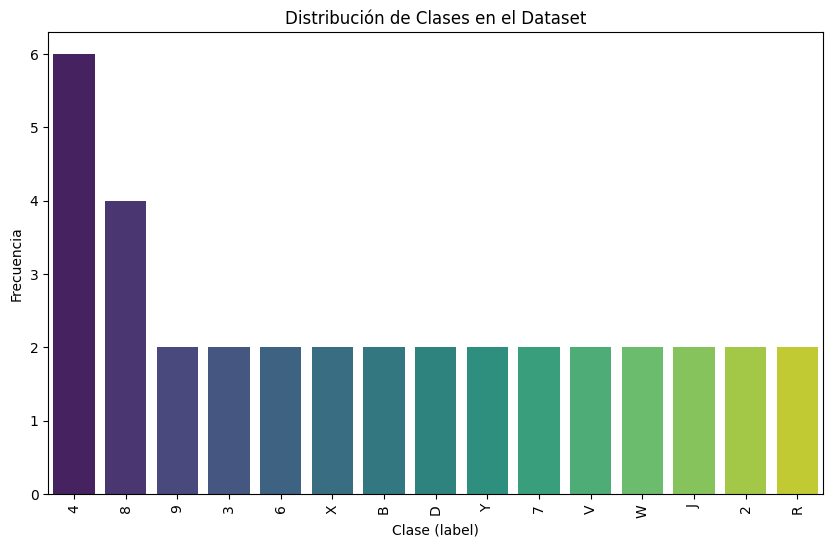

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
df = pd.read_csv("dataset.csv")

# Contar las ocurrencias de cada clase (label)
class_counts = df['label'].value_counts()

# Graficar la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribución de Clases en el Dataset")
plt.xlabel("Clase (label)")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
# Cargar imagen
imagen = Image.open("tipo1.png")

imagen = imagen.convert("L")

# Definir coordenadas de los recortes (x_inicio, y_inicio, x_fin, y_fin)
rectangulos = [
    (0, 5, 27, 32),  # Primer recorte
    (25, 16, 52, 43),   # Segundo recorte
    (50, 5, 77, 32),
    (75, 16, 102, 43),
    (100, 5, 127, 32),
    (125, 16, 152, 43)
]

# Recortar y guardar cada sección
for i, coords in enumerate(rectangulos):
    recorte = imagen.crop(coords)
    display(recorte)
    # recorte.save(f"recorte_{i+1}.jpg")  # Guardar recorte

# Dibujar rectángulos en la imagen original
dibujar = ImageDraw.Draw(imagen)
for coords in rectangulos:
    dibujar.rectangle(coords, outline="red", width=1)  # Rectángulo rojo

display(imagen)